In [10]:
import os
import random
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, GPT2ForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutputWithPast

from tqdm.notebook import tqdm

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [12]:
df = pd.read_csv("train_dataset_train.csv")
df = df[~df['Категория'].isin([2])]
df['Текст Сообщения'] = df['Текст Сообщения'].str.replace('[^а-яА-Я ]+', ' ')
test = pd.read_csv("test_dataset_test.csv")
test['Текст Сообщения'] = test['Текст Сообщения'].str.replace('[^а-яА-Я ]+', ' ')

/var/folders/cv/jbpz7rsj14v4dgfl5yv_3rqw0000gn/T/ipykernel_58061/966164517.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Текст Сообщения'] = df['Текст Сообщения'].str.replace('[^а-яА-Я ]+', ' ')
/var/folders/cv/jbpz7rsj14v4dgfl5yv_3rqw0000gn/T/ipykernel_58061/966164517.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test['Текст Сообщения'] = test['Текст Сообщения'].str.replace('[^а-яА-Я ]+', ' ')


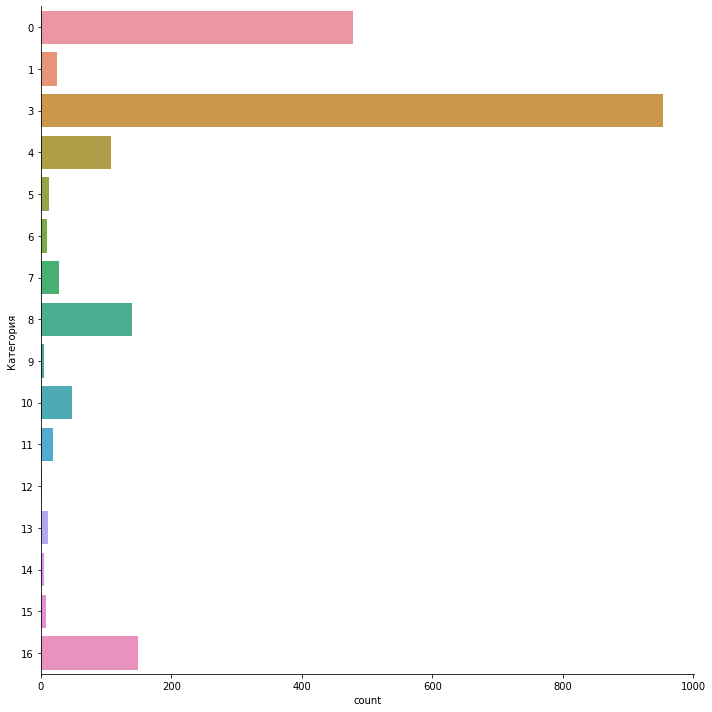

In [35]:
sns.catplot(y='Категория', kind="count", data=df, height=10)

In [17]:
df.groupby('Тематика')['Категория'].nunique()

Тематика
«Замороженная» стройка                                                                    1
Аварийное жильё                                                                           1
Аварийные деревья                                                                         1
Безнадзорные животные                                                                     1
Безопасная дорога в школу на дорогах в границах городских округов и сельских поселений    1
                                                                                         ..
Тарификация ж/д перевозок                                                                 1
Тестовая категория                                                                        1
Я хочу задать вопрос о вакцинации                                                         1
Ямы и выбоины на внутридворовых проездах и тротуарах  в районах многоквартирных домов     1
Ямы и выбоины на тротуарах                                             

In [14]:
df['category'] = df['Категория'].astype(str) + '_' + df['Тематика']

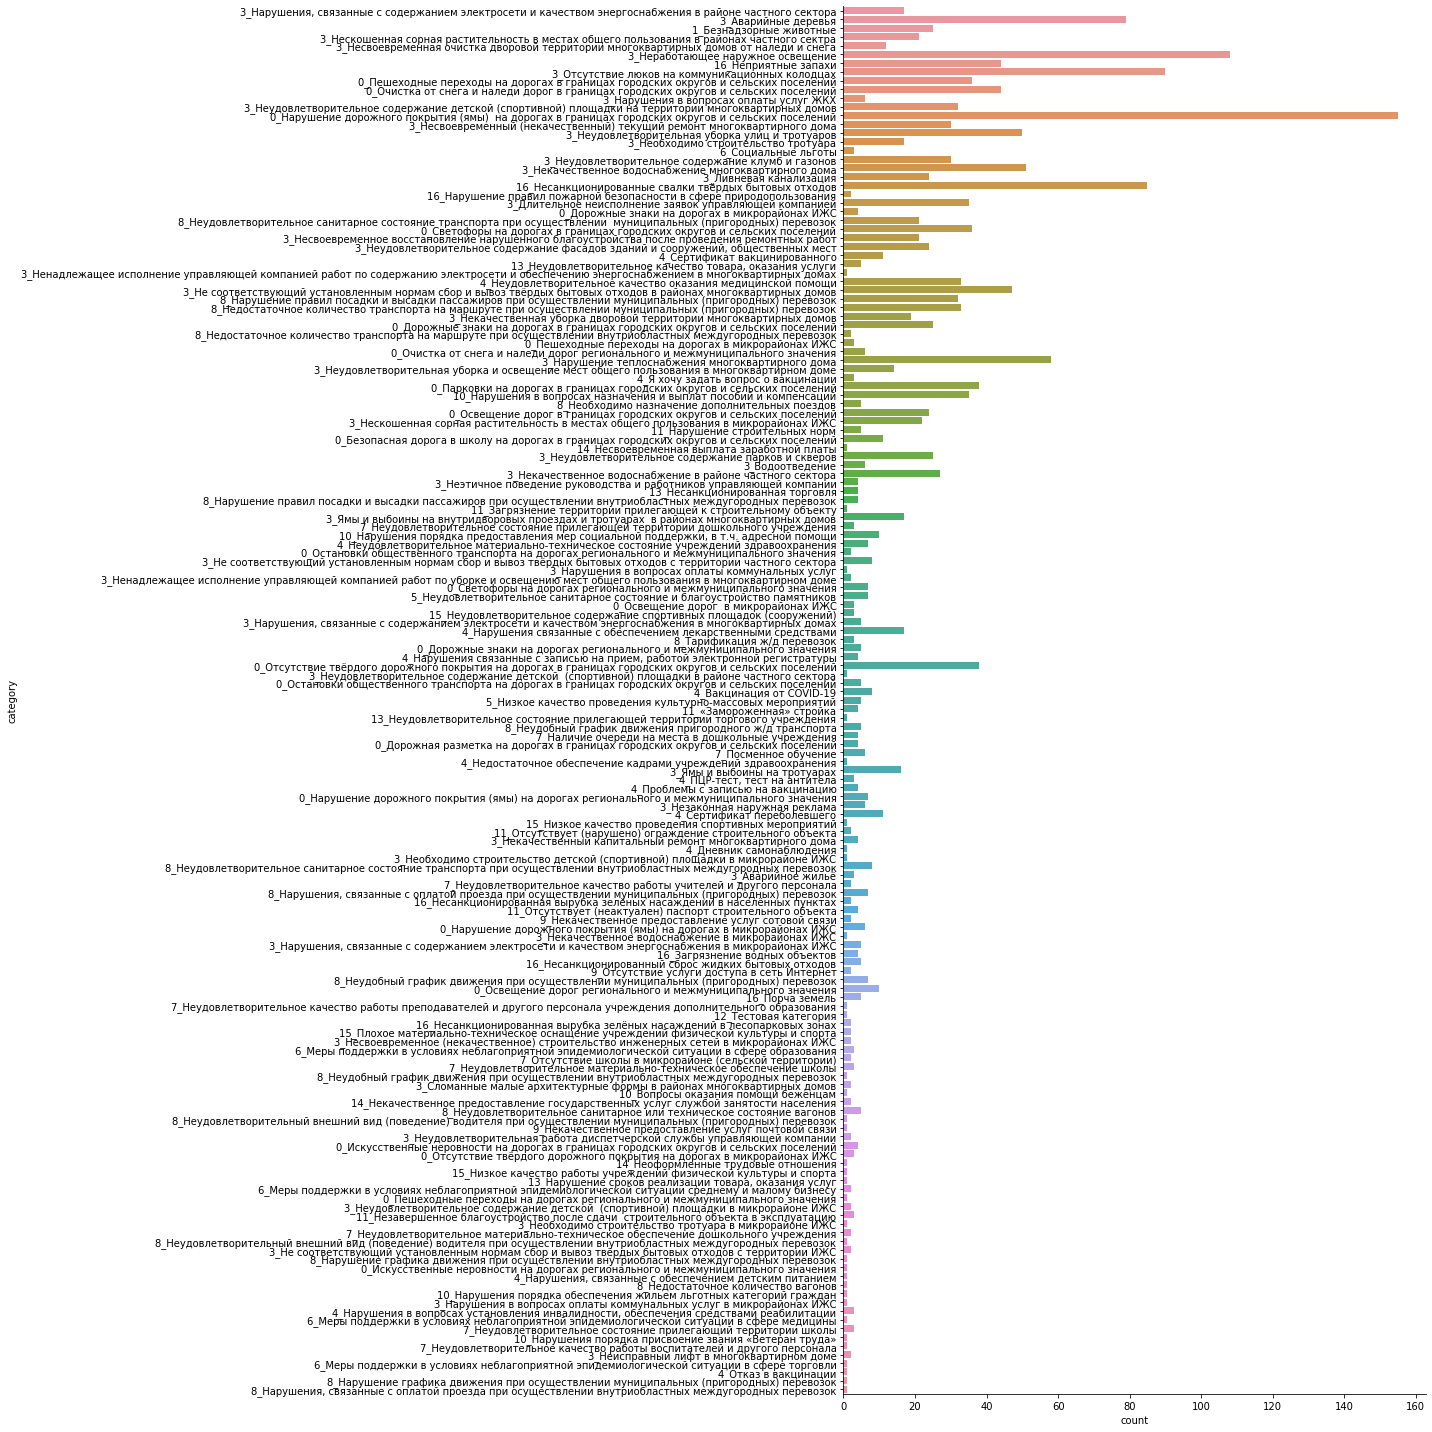

In [33]:
sns.catplot(y='category',kind="count", data=df, height=20)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(df['Текст Сообщения'], df['category'], test_size=0.1, random_state=0)

In [9]:
category2id = {cat:i for i, cat in enumerate(df['category'].unique())}

In [10]:
len(category2id)

159

In [11]:
device = 'cuda'
max_length = 512
batch_size = 1

In [5]:
os.environ['TOKENIZERS_PARALLELISM'] = 'False'
tokenizer = AutoTokenizer.from_pretrained('sberbank-ai/rugpt3medium_based_on_gpt2')
tokenizer.add_special_tokens({'pad_token': '<pad>'})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0

In [12]:
X_train  = [
            tokenizer.encode(q, max_length=max_length, padding='max_length', truncation=True, pad_to_max_length=True) 
            for q in tqdm(df['Текст Сообщения'].tolist())
]
X_train = [i if i else [0] * maxl for i in X_train]
X_train = torch.tensor(X_train)
y_train = torch.tensor(df['category'].map(category2id).tolist())
train_data = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=batch_size,
    num_workers=4,
    #pin_memory=True
)

  0%|          | 0/1997 [00:00<?, ?it/s]

In [13]:
X_val  = [
          tokenizer.encode(q, max_length=max_length, padding='max_length', truncation=True, pad_to_max_length=True) 
          for q in tqdm(X_val.tolist())
]
X_val = [i if i else [0] * maxl for i in X_val]
X_val = torch.tensor(X_val)
y_val = torch.tensor(y_val.map(category2id).tolist())
validation_data = TensorDataset(X_val, y_val)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=batch_size,
    num_workers=4,
    #pin_memory=True
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [14]:
class WeightedGPT2(GPT2ForSequenceClassification):

    def forward(
        self,
        input_ids=None,
        past_key_values=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        transformer_outputs = self.transformer(
            input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = transformer_outputs[0]
        logits = self.score(hidden_states)

        if input_ids is not None:
            batch_size, sequence_length = input_ids.shape[:2]
        else:
            batch_size, sequence_length = inputs_embeds.shape[:2]

        assert (
            self.config.pad_token_id is not None or batch_size == 1
        ), "Cannot handle batch sizes > 1 if no padding token is defined."
        if self.config.pad_token_id is None:
            sequence_lengths = -1
        else:
            if input_ids is not None:
                sequence_lengths = torch.ne(input_ids, self.config.pad_token_id).sum(-1) - 1
            else:
                sequence_lengths = -1
                logger.warning(
                    f"{self.__class__.__name__} will not detect padding tokens in `inputs_embeds`. Results may be "
                    f"unexpected if using padding tokens in conjunction with `inputs_embeds.`"
                )

        pooled_logits = logits[range(batch_size), sequence_lengths]

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(pooled_logits.view(-1), labels.to(self.dtype).view(-1))
            else:
                loss_fct = CrossEntropyLoss(weight=torch.tensor(compute_class_weight('balanced', classes=range(max(y_train)+1), y=y_train.tolist()), dtype=torch.float).to(device))
                loss = loss_fct(pooled_logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (pooled_logits,) + transformer_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutputWithPast(
            loss=loss,
            logits=pooled_logits,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
        )


In [15]:
model = WeightedGPT2.from_pretrained('sberbank-ai/rugpt3medium_based_on_gpt2', num_labels=len(category2id))
model.to(device)
model.config.pad_token_id = 0

Some weights of the model checkpoint at sberbank-ai/rugpt3small_based_on_gpt2 were not used when initializing WeightedGPT2: ['lm_head.weight']
- This IS expected if you are initializing WeightedGPT2 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WeightedGPT2 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WeightedGPT2 were not initialized from the model checkpoint at sberbank-ai/rugpt3small_based_on_gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-6)

/home/vladimir/.virtualenvs/ml/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
for _ in range(100):
    model.train()
    train_loss = 0
    
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
      
        optimizer.zero_grad()
      
        loss = model(b_input_ids.long(), token_type_ids=None, labels=b_labels)
        loss[0].backward()
        
        optimizer.step()
        
        train_loss += loss[0].item()
      
    print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))
    
    model.eval()

    valid_preds, valid_labels = [], []

    for batch in tqdm(validation_dataloader): 
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch

        with torch.no_grad():
            logits = model(b_input_ids.long(), token_type_ids=None)

        logits = logits[0].detach().cpu()
        label_ids = b_labels.to('cpu').numpy()

        batch_preds = torch.softmax(logits, axis=1).argmax(axis=1).numpy()
        batch_labels = label_ids
        valid_preds.extend(batch_preds)
        valid_labels.extend(batch_labels)

    valid_preds = np.array(valid_preds)
    print("f1: " + str(f1_score(valid_labels, valid_preds, average='micro')))

  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 5.18073


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.005


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 4.92276


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.04


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 4.66825


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.15


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 4.29088


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.325


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 3.73496


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.435


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 3.22868


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.535


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 2.82907


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.64


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 2.47236


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.69


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 2.16134


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.765


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 1.92361


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.785


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 1.72591


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.785


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 1.52562


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.825


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 1.32641


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.815


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 1.20793


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.865


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 1.03035


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.875


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.92593


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.89


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.85446


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.895


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.72419


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.9


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.65681


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.91


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.57239


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.92


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.52423


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.925


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.48326


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.935


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.42389


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.955


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.37506


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.9500000000000001


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.34261


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.9500000000000001


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.29989


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.97


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.26132


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.96


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.23615


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.97


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.20806


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.98


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.17340


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.985


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.16503


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.99


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.15989


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.985


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.13374


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.11541


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.99


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.10405


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.09856


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.08324


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.07150


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.06410


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.06072


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.06229


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.04791


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.04136


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.04217


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.03929


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.03466


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.03222


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.03183


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.02488


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.02451


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.02613


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.01840


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.01621


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.01461


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.01892


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.01526


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.01429


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.01414


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.01278


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00954


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00731


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.01516


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.01118


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00754


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00602


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00590


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00677


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.01191


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00979


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00695


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00478


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00651


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00480


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00684


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00742


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00456


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.99


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00530


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00406


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00522


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.99


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00395


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.99


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00638


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00551


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00363


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00533


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.99


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00415


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00251


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00415


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00553


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00595


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00262


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00299


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00293


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00253


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00360


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00444


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00232


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00236


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 0.995


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00185


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00131


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Loss на обучающей выборке: 0.00120


  0%|          | 0/50 [00:00<?, ?it/s]

f1: 1.0


In [18]:
test_texts = test['Текст Сообщения']

In [19]:
X_test  = [
           tokenizer.encode(q, max_length=max_length, padding='max_length', truncation=True, pad_to_max_length=True) 
           for q in tqdm(test_texts)
]
X_test = [i if i else [0] * maxl for i in X_test]
X_test = torch.tensor(X_test)
test_data = TensorDataset(X_test)
test_dataloader = DataLoader(
    test_data,
    sampler=SequentialSampler(test_data),
    batch_size=batch_size,
    num_workers=4,
    pin_memory=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
model.eval()

test_preds = []

for batch in tqdm(test_dataloader):   
    batch = batch[0]
    b_input_ids = batch.to(device)
    
    with torch.no_grad():
        logits = model(b_input_ids.long(), token_type_ids=None)

    logits = logits[0].detach().cpu()
    
    batch_preds = torch.softmax(logits, axis=1).argmax(axis=1).numpy()
    test_preds.extend(batch_preds)
    
test_preds = np.array(test_preds)

  0%|          | 0/250 [00:00<?, ?it/s]

In [21]:
categories = [i.split('_')[0] for i in category2id.keys()]

In [22]:
test_preds = [categories[i] for i in test_preds]

In [23]:
sample_submission = pd.DataFrame({'id': test['id'], 'Категория': test_preds})
sample_submission.to_csv('submission.csv', index=None)